# Guide to tHMM

In [1]:
import numpy as np
import scipy.stats as sp

### Synthesizing Cells (not required by the user)

In [2]:
from lineage.CellVar import CellVar as c
from lineage.CellVar import _double

In [3]:
T = np.array([[1.0, 0.0],
              [0.0, 1.0]])
    
parent_state = 1
parent_cell = c(state=parent_state, left=None, right=None, parent=None, gen=1)
left_cell, right_cell = parent_cell._divide(T)

In [4]:
print(left_cell, parent_cell.left)


 Generation: 2, State: 1, Observation: This cell has no observations to report. 
 Generation: 2, State: 1, Observation: This cell has no observations to report.


In [5]:
print(right_cell, parent_cell.right)


 Generation: 2, State: 1, Observation: This cell has no observations to report. 
 Generation: 2, State: 1, Observation: This cell has no observations to report.


## Creating a synthetic lineage (required by the user) "Two State Model"

In [6]:
from lineage.LineageTree import LineageTree
from lineage.StateDistribution import StateDistribution, get_experiment_time

### Creating a lineage and setting the full lineage (unpruned) as the one to be used

The required probabilities are those that define the tree and act of state switching. This process works by first creating a hidden tree of empty cells. Empty cells are those that have their states set but do not have any observations attached to them. We then draw as many observations from each state distribution and assign those observations to those cells. The $\pi$ and $T$ parameters are easy to define. The number of states is $k$. We require for $\pi$ a $k\times 1$ list of probabilities. These probabilities must add up to $1$ and they should be either in a $1$-dimensional list or a $1$-dimensional numpy array. The $T$ parameter should be a square numpy matrix of size $k\times k$. The rows are the states in which we are transitioning from and the columns are the states in which we are transitioning to. Each row of $T$ should sum to $1$. The columns need not sum to $1$.

In [7]:
# pi: the initial probability vector
pi = np.array([0.6, 0.4], dtype="float")

# T: transition probability matrix
T = np.array([[0.85, 0.15],
              [0.15, 0.85]])

The emission matrix $E$ is a little more complicated to define because this is where the user has complete freedom in defining what type of observation they care about. In particular, the user has to first begin with defining what observation he or she will want in their cells in their synthetic images. For example, if one is observing kinematics or physics, they might want to use Gaaussian distribution observations. In defining the random variables, the user will pull from a Gaussian distribution based on the mean and standard deviation of the different states he or she picks. They can also utilize the Gaussian probability distribution to define the likelihood as well. Furthermore, they can build an analytical estimator for their state distributions that yield the parameter estimates when given a list of observations. Finally, the user can also define a prune rule, which is essentially a boolean function that inspects a cell's observations and returns True if the cell's subtree (all the cells that are related to the cell in question and are of older generation) is to be pruned or False if the cell is safe from pruning. In the Gaussian example, a user can remove a cell's subtree if its observation is higher or lower than some fixed value.

We have already built, as an example, and as bioengineers, a model that resembles lineage trees. In our synthetic model, our emissions are multivariate. This first emission is a Bernoulli observation, $0$ implying death and $1$ implying division. The second and third emissions are continuous and are from exponential and gamma distributions respectively. Though these can be thought of cell lifetime's or periods in a certain cell phase, we want the user to know that these values can really mean anything and they are completely free in choosing what the emissions and their values mean. We define ways to calculate random variables for these multivariate observations and likelihoods of an observations. We also provide as a prune rule, keeping with the cell analogy, that if a cell has a $0$ in its Bernoulli observation, then its subtree is pruned from the full lineage tree. Though this will obviously introduce bias into estimation, we keep both the full tree and the pruned tree in the lineage objects, in the case a user would like to see the effects of analyzing on one versus the other.

Ultimately, $E$ is defined as a $k\times 1$ size list of state distribution objects. These distribution objects are rich in what they can already do, and a user can easily add more to their functionality. They only need to be instantiated by what parameters define that state's distribution.

In [8]:
# E: states are defined as StateDistribution objects

# State 0 parameters "Resistant"
state0 = 0
bern_p0 = 0.99
gamma_a0 = 20
gamma_scale0 = 5

# State 1 parameters "Susceptible"
state1 = 1
bern_p1 = 0.88
gamma_a1 = 10
gamma_scale1 = 1

state_obj0 = StateDistribution(state0, bern_p0, gamma_a0, gamma_scale0)
state_obj1 = StateDistribution(state1, bern_p1, gamma_a1, gamma_scale1)

E = [state_obj0, state_obj1]

The final required parameters are more obvious. The first is the desired number of cells one would like in their full unpruned lineage tree. This can be any number. The lineage tree is built 'from left to right'. What this means is that, we construct the binary tree by going to the left-most cell, dividing then walking through the generation. For example, if someone requested for

In [9]:
desired_num_cells = 2**7 - 1 
prune_boolean = False # To get the full tree

In [10]:
lineage1 = LineageTree(pi, T, E, desired_num_cells, prune_boolean)
print(lineage1)

This tree is NOT pruned. It is made of 2 states.
 For each state in this tree: 
 	 There are 47 cells of state 0, 
 	 There are 80 cells of state 1.
 This UNpruned tree has 127 cells in total


### Obtaining how long the experiment ran by checking the time length of the longest branch

In [11]:
longest_branch_time = get_experiment_time(lineage1)
print(longest_branch_time)

451.3387655750847


### Estimation of distribution parameters using our estimators for full lineage

In [12]:
for state in range(lineage1.num_states):
    print("State {}:".format(state))
    print("                    estimated state", E[state].estimator(lineage1.lineage_stats[state].full_lin_cells_obs))
    print("original parameters given for state", E[state])

State 0:
the number of gamma observations 47
                    estimated state State object w/ parameters: 0.9787234042532822, 22.640313669430718, 4.2880724327390105.
original parameters given for state State object w/ parameters: 0.99, 20, 5.
State 1:
the number of gamma observations 80
                    estimated state State object w/ parameters: 0.8374999999991563, 9.548667008968096, 1.0400552319049552.
original parameters given for state State object w/ parameters: 0.88, 10, 1.


### Estimation of distribution parameters using our estimators for pruned lineage

In [13]:
for state in range(lineage1.num_states):
    print("State {}:".format(state))
    print("                    estimated state", E[state].estimator(lineage1.lineage_stats[state].pruned_lin_cells_obs))
    print("original parameters given for state", E[state])

State 0:
the number of gamma observations 33
                    estimated state State object w/ parameters: 0.9999999999969699, 22.66215791031941, 4.459061665855774.
original parameters given for state State object w/ parameters: 0.99, 20, 5.
State 1:
the number of gamma observations 70
                    estimated state State object w/ parameters: 0.8142857142848163, 9.588552119811556, 1.0264018488982238.
original parameters given for state State object w/ parameters: 0.88, 10, 1.


### Analyzing our first full lineage

In [14]:
from lineage.Analyze import Analyze

X = [lineage1] # population just contains one lineage
states = [cell.state for cell in lineage1.output_lineage]
print(states)
deltas, state_ptrs, all_states, tHMMobj, NF, LL = Analyze(X, 2) # find two states

[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1]
the number of gamma observations 111
the number of gamma observations 16
[-575.2181141636793]
the number of gamma observations 101
the number of gamma observations 26
[-566.8029354127902]
the number of gamma observations 74
the number of gamma observations 53
[-552.5085756207486]
the number of gamma observations 55
the number of gamma observations 72
[-511.68447111308905]
the number of gamma observations 47
the number of gamma observations 80
[-467.96444677756597]
the number of gamma observations 47
the number of gamma observations 80
[-467.9243858369414]
the number of gamma observations 47
the number of gamma 

In [15]:
tHMMobj.estimate.E[0]

State object w/ parameters: 0.9787234042532822, 22.640313669430718, 4.2880724327390105.

In [16]:
for num, lineageObj in enumerate(X):
    lin_estimated_states = all_states[num]
    lin_true_states = [cell.state for cell in lineageObj.output_lineage]
    total = len(lin_estimated_states)
    assert total == len(lin_true_states)
    counter = [1 if a==b else 0 for (a,b) in zip(lin_estimated_states,lin_true_states)]
    print("Accuracy or 1-Accuracy is {}".format(sum(counter)/total))

Accuracy or 1-Accuracy is 1.0


In [17]:
import matplotlib.pyplot as plt
for state in range(lineage1.num_states):
    askjdha, sduhfksj = list(zip(*lineage1.lineage_stats[state].pruned_lin_cells_obs))
    plt.hist(sduhfksj)
    plt.show()


<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

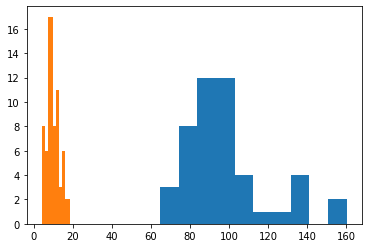

In [18]:
for state in range(lineage1.num_states):
    askjdha, sduhfksj = list(zip(*lineage1.lineage_stats[state].full_lin_cells_obs))
    plt.hist(sduhfksj)

### Estimated Markov parameters ($\pi$, $T$, $E$)

In [19]:
print(tHMMobj.estimate.pi)

[2.4045669e-34 1.0000000e+00]


In [20]:
print(tHMMobj.estimate.T)

[[0.825     0.175    ]
 [0.1627907 0.8372093]]


In [21]:
for state in range(tHMMobj.numStates):
    print(tHMMobj.estimate.E[state])

State object w/ parameters: 0.9787234042532822, 22.640313669430718, 4.2880724327390105.
State object w/ parameters: 0.8374999999991563, 9.548667008968096, 1.0400552319049552.


## Trying another lineage, this time pruning branches with ancestors that die

In [22]:
desired_num_cells = 2**12 -1 
prune_boolean = True # To get pruned tree

In [23]:
lineage2 = LineageTree(pi, T, E, desired_num_cells, prune_boolean)
print(lineage2)

This tree is pruned. It is made of 2 states.
 For each state in this tree: 
 	 There are 1621 cells of state 0, 
 	 There are 1152 cells of state 1.
 This pruned tree has 2773 cells in total


In [24]:
longest2 = get_experiment_time(lineage2)
print(longest2)

1427.759507949805


### Estimation of distribution parameters using our estimators for pruned lineage

In [25]:
for state in range(lineage2.num_states):
    print("State {}:".format(state))
    print("                    estimated state", E[state].estimator(lineage2.lineage_stats[state].pruned_lin_cells_obs))
    print("original parameters given for state", E[state])

State 0:
the number of gamma observations 1621
                    estimated state State object w/ parameters: 0.9919802590992607, 19.70766154376009, 5.110304283766435.
original parameters given for state State object w/ parameters: 0.99, 20, 5.
State 1:
the number of gamma observations 1152
                    estimated state State object w/ parameters: 0.8776041666666011, 9.770136459751448, 1.021242618431839.
original parameters given for state State object w/ parameters: 0.88, 10, 1.


### Analyzing a population of lineages

In [26]:
X = [lineage1, lineage2] # population just contains one lineage

deltas, state_ptrs, all_states, tHMMobj, NF, LL = Analyze(X, 2) # find two states

0.0 160.03709329532185 2.439194856213444 0.20704955706124062
0.0 163.86831082234943 2.439194856213444 0.20704955706124062
0.0 158.8459960984122 2.439194856213444 0.20704955706124062
0.0 158.17500756201431 2.439194856213444 0.20704955706124062
0.0 191.94875308228586 2.439194856213444 0.20704955706124062
0.0 166.7165540868868 2.439194856213444 0.20704955706124062
0.0 165.83157092119143 2.439194856213444 0.20704955706124062
0.0 159.36093178665442 2.439194856213444 0.20704955706124062
0.0 166.34333233861466 2.439194856213444 0.20704955706124062
0.0 165.28998526690373 2.439194856213444 0.20704955706124062
0.0 179.53738418535437 2.439194856213444 0.20704955706124062
0.0 156.95246157496712 2.439194856213444 0.20704955706124062
0.0 169.80066365916917 2.439194856213444 0.20704955706124062
0.0 157.5121383742712 2.439194856213444 0.20704955706124062
0.0 160.13827275088784 2.439194856213444 0.20704955706124062
0.0 163.07785085471124 2.439194856213444 0.20704955706124062
0.0 163.47817993477435 2.43

In [27]:
for num, lineageObj in enumerate(X):
    lin_estimated_states = all_states[num]
    lin_true_states = [cell.state for cell in lineageObj.output_lineage]
    total = len(lin_estimated_states)
    assert total == len(lin_true_states)
    counter = [1 if a==b else 0 for (a,b) in zip(lin_estimated_states,lin_true_states)]
    print("Accuracy or 1-Accuracy is {}".format(sum(counter)/total))

Accuracy or 1-Accuracy is 0.6299212598425197
Accuracy or 1-Accuracy is 0.4194013703570141


### Estimated Markov parameters ($\pi$, $T$, $E$)

In [28]:
print(tHMMobj.estimate.pi)

[1.27731107e-125 1.00000000e+000]


In [29]:
print(tHMMobj.estimate.T)

[[3.08677015e-08 9.99999969e-01]
 [8.47733190e-06 9.99991523e-01]]


In [30]:
for state in range(tHMMobj.numStates):
    print(tHMMobj.estimate.E[state])

State object w/ parameters: 0.5, 10, 1.
State object w/ parameters: 0.9420689655172109, 1.1262919715413717, 55.141604381205326.


## Creating a synthetic lineage that has three states

Here we generate a lineage with three states, which would be 1) Susciptible 2) Middle State 3) Resistant. The aim here is to show the transition from susciptible to resistant state doesn't happen immediately, and there is a gradual transition which is modeled as a middle state. The point to be considered here is that transition from 1 to 3 or otherwise is not possible so the probability of these transitions are zero, and most likely the initial cells are in susciptible state.

**State 1**: Susceptible

**State 2**: Transition state

**State 3**: Resistant state


In [31]:
# pi: the initial probability vector
pi_3 = np.array([0.5, 0.25, 0.25])

# T: transition probability matrix
T_3 = np.array([[0.65, 0.35, 0.00],
                [0.20, 0.40, 0.40],
                [0.00, 0.10, 0.90]])

In [32]:
# E: states are defined as StateDistribution objects

# State 0 parameters "Susciptible"
state0 = 0
bern_p0 = 0.7
expon_scale_beta0 = 20
gamma_a0 = 5.0
gamma_scale0 = 1.0

# State 1 parameters "Middle state"
state1 = 1
bern_p1 = 0.85
expon_scale_beta1 = 60
gamma_a1 = 10.0
gamma_scale1 = 2.0

# State 2 parameters "Resistant"
state2 = 2
bern_p2 = 0.99
expon_scale_beta2 = 80
gamma_a2 = 15.0
gamma_scale2 = 3.0

state_obj0 = StateDistribution(state0, bern_p0, gamma_a0, gamma_scale0)
state_obj1 = StateDistribution(state1, bern_p1, gamma_a1, gamma_scale1)
state_obj2 = StateDistribution(state2, bern_p2, gamma_a2, gamma_scale2)

E_3 = [state_obj0, state_obj1, state_obj2]

In [33]:
desired_num_cells = 2**13 - 1 
prune_boolean = False # To get the full tree

In [34]:
lineage3 = LineageTree(pi_3, T_3, E_3, desired_num_cells, prune_boolean)
print(lineage3)

This tree is NOT pruned. It is made of 3 states.
 For each state in this tree: 
 	 There are 930 cells of state 0, 
 	 There are 1552 cells of state 1, 
 	 There are 5709 cells of state 2.
 This UNpruned tree has 8191 cells in total


In [35]:
longest3 = get_experiment_time(lineage3)
print(longest3)

639.6409830839934


### Estimation of distribution parameters using our estimators for full lineage (3 state)

In [36]:
for state in range(lineage3.num_states):
    print("State {}:".format(state))
    print("estimated state", E_3[state].estimator(lineage3.lineage_stats[state].full_lin_cells_obs))
    print("estimated state", E_3[state].estimator(lineage3.lineage_stats[state].pruned_lin_cells_obs))
    print("true_____ state", E_3[state])

State 0:
the number of gamma observations 930
estimated state State object w/ parameters: 0.7032258064515693, 4.767145766359264, 1.0608943536430964.
the number of gamma observations 1
estimated state State object w/ parameters: 9.999999998e-11, 10, 1.
true_____ state State object w/ parameters: 0.7, 5.0, 1.0.
State 1:
the number of gamma observations 1552
estimated state State object w/ parameters: 0.8543814432989234, 9.850076130798644, 2.0464233969476684.
estimated state State object w/ parameters: 0.5, 10, 1.
true_____ state State object w/ parameters: 0.85, 10.0, 2.0.
State 2:
the number of gamma observations 5709
estimated state State object w/ parameters: 0.9898406025573484, 15.000373137007418, 2.996553114812564.
estimated state State object w/ parameters: 0.5, 10, 1.
true_____ state State object w/ parameters: 0.99, 15.0, 3.0.


### Analyzing a three state lineage

In [37]:
X = [lineage3] # population just contains one lineage

deltas, state_ptrs, all_states, tHMMobj, NF, LL = Analyze(X, 3) # find three states

the number of gamma observations 38
the number of gamma observations 7853
the number of gamma observations 300
[-35556.68720328576]
the number of gamma observations 55
the number of gamma observations 7346
the number of gamma observations 790
[-33757.3949286443]
the number of gamma observations 106
the number of gamma observations 7102
the number of gamma observations 983
[-33429.428385184896]
the number of gamma observations 132
the number of gamma observations 6995
the number of gamma observations 1064
[-33331.8546215589]
the number of gamma observations 131
the number of gamma observations 6881
the number of gamma observations 1179
[-33241.033479482656]
the number of gamma observations 126
the number of gamma observations 6782
the number of gamma observations 1283
[-33171.323093053084]
the number of gamma observations 126
the number of gamma observations 6690
the number of gamma observations 1375
[-33110.76912726175]
the number of gamma observations 159
the number of gamma observati

In [38]:
for num, lineageObj in enumerate(X):
    lin_estimated_states = all_states[num]
    lin_true_states = [cell.state for cell in lineageObj.output_lineage]
    total = len(lin_estimated_states)
    assert total == len(lin_true_states)
    counter = [1 if a==b else 0 for (a,b) in zip(lin_estimated_states,lin_true_states)]
    print("Accuracy {}".format(sum(counter)/total))

Accuracy 0.06775729459162495


### Estimated Markov parameters ($\pi$, $T$, $E$)

In [39]:
print(tHMMobj.estimate.pi)

[2.44320586e-03 4.64013775e-90 9.97556794e-01]


In [40]:
print(tHMMobj.estimate.T)

[[7.68514632e-04 6.54276751e-01 3.44954734e-01]
 [6.83222493e-03 9.45225074e-01 4.79427013e-02]
 [7.27002591e-06 1.92370549e-01 8.07622181e-01]]


In [41]:
for state in range(tHMMobj.numStates):
    print(tHMMobj.estimate.E[state].shape[0])

AttributeError: 'StateDistribution' object has no attribute 'shape'

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
A = sp.gamma.rvs(a=20,scale=4,size=2)
B = sp.gamma.rvs(a=5,scale=1,size=1000)
plt.hist(A)
plt.figure()
plt.hist(B)

In [ ]:
from lineage.StateDistribution import gamma_estimator 
a, b = gamma_estimator(A)

In [ ]:
import scipy.stats as sp
gamma_ll = sp.gamma.pdf(x=A, a=a, scale=b)  # gamma likelihood
print(gamma_ll)